In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../GloVe'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../GloVe\glove.6B.100d.txt
../GloVe\glove.6B.200d.txt
../GloVe\glove.6B.300d.txt
../GloVe\glove.6B.50d.txt
../GloVe\glove.6B.zip
../GloVe\glove.840B.300d.txt
../GloVe\glove.840B.300d.zip
../GloVe\GoogleNews-vectors-negative300.bin
../GloVe\GoogleNews-vectors-negative300.bin.gz


In [2]:
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential

from keras.layers import Dense, LSTM, Flatten, Embedding
from tensorflow.keras.utils import to_categorical
from keras.backend import clear_session

In [3]:
filename = "../GloVe/GoogleNews-vectors-negative300.bin"

start = time.time()
google_embeddings = KeyedVectors.load_word2vec_format(filename, binary=True)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  35.94637584686279


In [4]:
# load Stanford's pre-trained GloVe embeddings
glove_file = "../GloVe/glove.6B.300d.txt"
glove_word2vec_file = "glove.6B.100d.txt.word2vec"

glove2word2vec(glove_file, glove_word2vec_file)

<ipython-input-4-5b0fe62de465>:5: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_file, glove_word2vec_file)


(400000, 300)

In [5]:
# glove embeddings
start = time.time()

glove_embeddings = KeyedVectors.load_word2vec_format(glove_word2vec_file, binary=False)

print("Load time (seconds): ", (time.time() - start))

Load time (seconds):  93.06851983070374


In [6]:
data = pd.read_csv("../Data/preprocessed.csv")

# view first 5 rows of the dataframe 'data'
data.head()

X-Folder                                               text
0  california  caiso notice summer 2001 generation rfb market...
1  california  ca iso cal px information related 2000 market ...
2  california  caiso notification update inter sc trades adju...
3  california  update mif meeting presentations iso website u...
4  california  mif presentations presentations market issues ...

In [7]:
# count number of instances in each folder
data['X-Folder'].unique()

array(['california', 'calendar', 'resumes', 'archives', 'junk file',
       'ces', 'logistics', 'tufco', 'projects', 'online trading',
       'management', 'esvl', 'ooc', 'corporate', 'tw-commercial group',
       'genco-jv_ipo', 'junk', 'deal discrepancies', 'e-mail bin',
       'bill williams iii'], dtype=object)

In [8]:
def label_encoder(data):
    class_le = LabelEncoder()
    # apply label encoder on the 'X-Folder' column
    y = class_le.fit_transform(data['X-Folder'])
    return y

In [9]:
y = label_encoder(data)
input_data = data['text']

In [40]:
input_data

0        caiso notice summer 2001 generation rfb market...
1        ca iso cal px information related 2000 market ...
2        caiso notification update inter sc trades adju...
3        update mif meeting presentations iso website u...
4        mif presentations presentations market issues ...
                               ...                        
13581    duke westcoast transaction dial number 216 090...
13582    duke westcoast transaction sent behalf peter k...
13583    updated edcc ecc pricing discussion would like...
13584    aes project tolling interest mtg derek dennist...
13585    transfer enron direct contracts ed marking inc...
Name: text, Length: 13586, dtype: object

In [11]:
# split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(input_data, y, test_size=0.1)

In [12]:
# one-hot encode the output labels
Y_train = to_categorical(y_train, 20)
Y_test = to_categorical(y_test, 20)

In [57]:
X_train[20]

'great news ferc order morgan stanley complaint iso dan douglass summarized really puts ca iso notice cannot confiscate power seem ready ferc reiterates generators sell power wherever want cap cap iso purchases iso want set sale price cap file ferc wait 60 days amend contract forwarded susan j mara sfo ees 08 01 2000 01 01 daniel douglass douglass arterhadden com 07 31 2000 07 27 24 pm peter bray att net jbarthrop electric com mnelson electric com rschlanert electric com bruno gaillard enron com kmagrude enron com mpetroch enron com susan j mara enron com athomas newenergy com bchen newenergy com jeff hanson phaser com anchau shellus com andrew madden utility com ben reyes utility com chris king utility com david bayless utility com cc subject ferc order morgan stanley complaint iso good news iso price caps front ferc made clear iso ability mandate generators sell iso price caps proper response inadequate supply lift price caps friday ferc issued order complaint connection july 10 comp

In [13]:
# prepare tokenizer
t = Tokenizer()

# fit the tokenizer on the docs
t.fit_on_texts(input_data)
vocab_size = len(t.word_index) + 1

# integer encode the documents
X_train_encoded_docs = t.texts_to_sequences(X_train)
X_test_encoded_docs = t.texts_to_sequences(X_test)

In [44]:
t.word_index.items()

dict_items([('enron', 1), ('20', 2), ('com', 3), ('ect', 4), ('hou', 5), ('please', 6), ('e', 7), ('1', 8), ('2', 9), ('subject', 10), ('2001', 11), ('http', 12), ('energy', 13), ('power', 14), ('gas', 15), ('would', 16), ('2000', 17), ('pm', 18), ('01', 19), ('cc', 20), ('10', 21), ('www', 22), ('0', 23), ('00', 24), ('thanks', 25), ('3', 26), ('california', 27), ('new', 28), ('mail', 29), ('deal', 30), ('said', 31), ('02', 32), ('09', 33), ('know', 34), ('time', 35), ('state', 36), ('message', 37), ('11', 38), ('12', 39), ('sent', 40), ('need', 41), ('may', 42), ('000', 43), ('4', 44), ('5', 45), ('us', 46), ('market', 47), ('also', 48), ('corp', 49), ('2002', 50), ('day', 51), ('let', 52), ('p', 53), ('information', 54), ('one', 55), ('vince', 56), ('original', 57), ('meeting', 58), ('30', 59), ('call', 60), ('rigzone', 61), ('attached', 62), ('get', 63), ('company', 64), ('price', 65), ('questions', 66), ('see', 67), ('ees', 68), ('j', 69), ('group', 70), ('like', 71), ('03', 72), 

In [42]:
# pad documents to a max length of 150 words
max_length = 150
X_train_padded_docs = pad_sequences(X_train_encoded_docs, maxlen=max_length, padding='post')
X_test_padded_docs = pad_sequences(X_test_encoded_docs, maxlen=max_length, padding='post')

len(X_train_padded_docs)

12227

In [15]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = google_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [50]:
embedding_matrix[65]

array([-1.41969994e-01,  3.00570011e-01,  4.45169985e-01,  5.10270000e-01,
        2.20909998e-01,  3.27300012e-01, -2.78760010e-04,  6.97930008e-02,
        4.12539989e-02, -1.94860005e+00, -4.09339994e-01, -1.70910005e-02,
        3.83730009e-02,  1.28600001e-01,  1.23980001e-01,  1.31970001e-02,
        1.71709999e-01, -1.69500001e-02, -4.13450003e-01, -2.21120000e-01,
        2.09910005e-01,  3.79559994e-01,  5.24659991e-01, -1.15460001e-01,
        3.74289989e-01,  2.62030005e-01,  1.23219997e-01,  1.74089998e-01,
       -3.48450005e-01, -5.80439985e-01, -5.18469989e-01,  2.19200000e-01,
       -6.68900013e-01,  4.17299986e-01, -1.21560001e+00,  1.96250007e-01,
       -2.16309994e-01, -3.66039991e-01, -1.70580000e-01,  1.62540004e-02,
       -4.59289998e-01, -2.74969995e-01,  1.03189997e-01,  5.07219970e-01,
       -4.32460010e-02, -3.71639997e-01, -2.70069987e-01, -3.40970010e-02,
        2.83190012e-01,  2.79749990e-01,  5.93990028e-01, -1.67260006e-01,
       -5.37169993e-01, -

In [17]:
# define the model
model = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model.add(e)
model.add(LSTM(100, dropout=0.2))
model.add(Flatten())
model.add(Dense(20, activation='softmax'))


# compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          17877600  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 18,040,020
Trainable params: 162,420
Non-trainable params: 17,877,600
_________________________________________________________________


In [18]:
clear_session()

In [19]:
# train the model
clear_session()
history = model.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

Epoch 1/60
344/344 [==============================] - 83s 235ms/step - loss: 2.9021 - accuracy: 0.1030 - val_loss: 2.8456 - val_accuracy: 0.1267
Epoch 2/60
344/344 [==============================] - 80s 233ms/step - loss: 2.8806 - accuracy: 0.1187 - val_loss: 2.8436 - val_accuracy: 0.1276
Epoch 3/60
344/344 [==============================] - 80s 232ms/step - loss: 2.8225 - accuracy: 0.1313 - val_loss: 2.7948 - val_accuracy: 0.1267
Epoch 4/60
344/344 [==============================] - 80s 234ms/step - loss: 2.7883 - accuracy: 0.1377 - val_loss: 2.7539 - val_accuracy: 0.1537
Epoch 5/60
344/344 [==============================] - 80s 234ms/step - loss: 2.7900 - accuracy: 0.1425 - val_loss: 2.8522 - val_accuracy: 0.1300
Epoch 6/60
344/344 [==============================] - 81s 235ms/step - loss: 2.8117 - accuracy: 0.1375 - val_loss: 2.7814 - val_accuracy: 0.1423
Epoch 7/60
344/344 [==============================] - 81s 234ms/step - loss: 2.7782 - accuracy: 0.1459 - val_loss: 2.7634 - val_ac

344/344 [==============================] - 63s 184ms/step - loss: 0.2921 - accuracy: 0.9018 - val_loss: 1.1029 - val_accuracy: 0.7261
Epoch 58/60
344/344 [==============================] - 66s 193ms/step - loss: 0.2768 - accuracy: 0.9049 - val_loss: 1.1036 - val_accuracy: 0.7179
Epoch 59/60
344/344 [==============================] - 67s 196ms/step - loss: 0.2638 - accuracy: 0.9108 - val_loss: 1.2577 - val_accuracy: 0.7138
Epoch 60/60
344/344 [==============================] - 67s 195ms/step - loss: 0.2671 - accuracy: 0.9080 - val_loss: 1.1773 - val_accuracy: 0.7073


In [20]:
# evaluate the model on the test set
accr = model.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr[0], accr[1]))

43/43 [==============================] - 3s 78ms/step - loss: 1.2543 - accuracy: 0.6968
Test Set: 
 Loss: 1.254
 Accuracy: 0.697


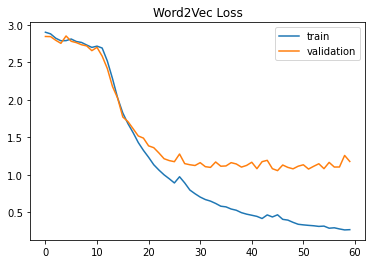

In [21]:
# plot the loss
plt.title("Word2Vec Loss")
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

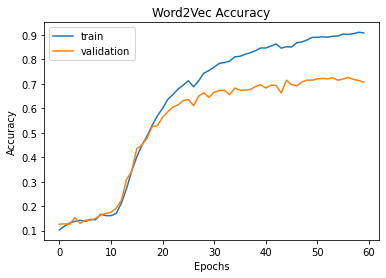

In [22]:
# plot the accuracy
plt.title("Word2Vec Accuracy")
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [23]:
# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 300))

for word, i in t.word_index.items():
    
    try:
        embedding_vector = glove_embeddings[word]
    
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector 
    except:
        pass

In [24]:
# define the model
model2 = Sequential()
e = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)
model2.add(e)
model2.add(LSTM(100, dropout=0.2))
model2.add(Flatten())
model2.add(Dense(20, activation='softmax'))


# compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model2.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          17877600  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 20)                2020      
Total params: 18,040,020
Trainable params: 162,420
Non-trainable params: 17,877,600
_________________________________________________________________


In [25]:
# fit the model
history2 = model2.fit(X_train_padded_docs, Y_train, epochs=60, verbose=1, validation_split=0.1)

Epoch 1/60
344/344 [==============================] - 66s 187ms/step - loss: 2.9027 - accuracy: 0.1065 - val_loss: 2.8222 - val_accuracy: 0.1169
Epoch 2/60
344/344 [==============================] - 62s 181ms/step - loss: 2.8362 - accuracy: 0.1231 - val_loss: 2.7894 - val_accuracy: 0.1316
Epoch 3/60
344/344 [==============================] - 60s 174ms/step - loss: 2.8025 - accuracy: 0.1360 - val_loss: 2.7630 - val_accuracy: 0.1529
Epoch 4/60
344/344 [==============================] - 58s 169ms/step - loss: 2.7735 - accuracy: 0.1473 - val_loss: 2.7274 - val_accuracy: 0.1668
Epoch 5/60
344/344 [==============================] - 58s 169ms/step - loss: 2.6825 - accuracy: 0.1676 - val_loss: 2.7207 - val_accuracy: 0.1725
Epoch 6/60
344/344 [==============================] - 69s 201ms/step - loss: 2.6628 - accuracy: 0.1883 - val_loss: 2.7100 - val_accuracy: 0.1742
Epoch 7/60
344/344 [==============================] - 67s 194ms/step - loss: 2.6322 - accuracy: 0.1874 - val_loss: 2.6038 - val_ac

344/344 [==============================] - 56s 164ms/step - loss: 0.3526 - accuracy: 0.8894 - val_loss: 1.1386 - val_accuracy: 0.7228
Epoch 58/60
344/344 [==============================] - 56s 164ms/step - loss: 0.3062 - accuracy: 0.8997 - val_loss: 1.1702 - val_accuracy: 0.7343
Epoch 59/60
344/344 [==============================] - 56s 163ms/step - loss: 0.2904 - accuracy: 0.9053 - val_loss: 1.1489 - val_accuracy: 0.7392
Epoch 60/60
344/344 [==============================] - 56s 164ms/step - loss: 0.2753 - accuracy: 0.9093 - val_loss: 1.1970 - val_accuracy: 0.7269


In [26]:
# evaluate the model2 on the test set
accr2 = model2.evaluate(X_test_padded_docs, Y_test)
print("Test Set: \n Loss: {:0.3f}\n Accuracy: {:0.3f}".format(accr2[0], accr2[1]))

43/43 [==============================] - 3s 62ms/step - loss: 1.0875 - accuracy: 0.7388
Test Set: 
 Loss: 1.087
 Accuracy: 0.739


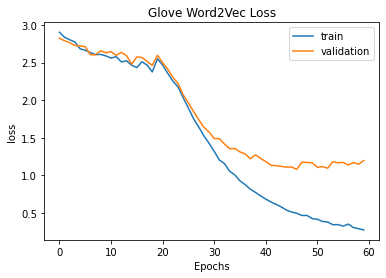

In [27]:
# plot the loss
plt.title("Glove Word2Vec Loss")
plt.plot(history2.history['loss'], label='train')
plt.plot(history2.history['val_loss'], label='validation')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("loss")
plt.show()

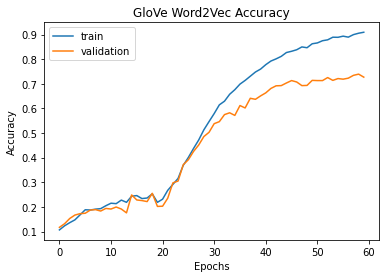

In [28]:
# plot the accuracy
plt.title("GloVe Word2Vec Accuracy")
plt.plot(history2.history['accuracy'], label='train')
plt.plot(history2.history['val_accuracy'], label='validation')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.show()

In [29]:


# define the model
model3 = Sequential()
model3.add(Embedding(vocab_size, 300, input_length=max_length))
model3.add(LSTM(100, dropout=0.4))
model3.add(Flatten())
model3.add(Dense(20, activation='softmax'))

# compile the model
model3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# summarize the model
model3.summary()



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 300)          17877600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                2020      
Total params: 18,040,020
Trainable params: 18,040,020
Non-trainable params: 0
_________________________________________________________________


In [30]:
# train the model
history3 = model3.fit(X_train_padded_docs, Y_train, validation_split=0.1, epochs=20, verbose=1)

Epoch 1/20
344/344 [==============================] - 113s 326ms/step - loss: 2.9006 - accuracy: 0.1071 - val_loss: 2.8232 - val_accuracy: 0.1284
Epoch 2/20
344/344 [==============================] - 111s 323ms/step - loss: 2.8079 - accuracy: 0.1284 - val_loss: 2.7680 - val_accuracy: 0.1431
Epoch 3/20
344/344 [==============================] - 111s 324ms/step - loss: 2.7427 - accuracy: 0.1532 - val_loss: 2.7221 - val_accuracy: 0.1554
Epoch 4/20
344/344 [==============================] - 116s 336ms/step - loss: 2.6805 - accuracy: 0.1665 - val_loss: 2.7146 - val_accuracy: 0.1594
Epoch 5/20
344/344 [==============================] - 111s 322ms/step - loss: 2.6571 - accuracy: 0.1787 - val_loss: 2.7167 - val_accuracy: 0.1586
Epoch 6/20
344/344 [==============================] - 110s 320ms/step - loss: 2.6809 - accuracy: 0.1776 - val_loss: 2.7718 - val_accuracy: 0.1562
Epoch 7/20
344/344 [==============================] - 109s 318ms/step - loss: 2.5785 - accuracy: 0.2016 - val_loss: 2.4802 -

In [58]:
import pickle

with open('../results/own_embeddings.pkl', 'rb') as f:
    data = pickle.load(f)

In [59]:
data

{'enron': array([ 0.06402528, -0.1091108 , -0.01031563,  0.13188906, -0.04310052,
        -0.08137896,  0.11460854, -0.00421803, -0.13300674,  0.044225  ,
         0.12928645,  0.03766093,  0.00889021,  0.15462986,  0.18620269,
        -0.00445883, -0.01640196, -0.06398223, -0.02318321,  0.07481349,
         0.00477386, -0.04469626, -0.03060198,  0.03685304,  0.00936557,
         0.02469636, -0.10268562,  0.02660015,  0.05660224, -0.05871567,
         0.04860458, -0.09855082,  0.07725956,  0.01732212, -0.0407257 ,
        -0.03037932,  0.07672304, -0.077078  ,  0.03338823, -0.03749686,
         0.04046681,  0.05150168,  0.01703547,  0.03911036, -0.05829893,
        -0.00158653,  0.12100423,  0.04366868,  0.06439985, -0.05426567,
        -0.02736019,  0.01114854,  0.02574447, -0.0426485 , -0.02930125,
         0.01019616,  0.02524042,  0.0874393 , -0.09262633, -0.0201379 ,
        -0.00335018,  0.03426473,  0.06207858,  0.14559622,  0.03008261,
         0.05308117,  0.11432357, -0.14007